In [1]:
import pandas as pd
import numpy as np
import os

from typing import List, Tuple

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import missingno as msno

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')


pd.options.display.max_rows=100
pd.options.display.max_columns=250

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'ATaganova_submission.csv',
 'EDA.ipynb',
 'EDA_ProfileReport.ipynb',
 'Model.ipynb',
 'row_data']

In [3]:
def get_input(data_path):
    data = pd.read_csv(data_path)
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [4]:
path = 'row_data'
os.listdir(path)

['applications_history.csv',
 'bki.csv',
 'client_profile.csv',
 'payments.csv',
 'test.csv',
 'train.csv']

In [5]:
train_df = get_input(f'{path}/train.csv')
test_df = get_input(f'{path}/test.csv')

row_data/train.csv: shape = 110093 rows, 3 cols
row_data/test.csv: shape = 165141 rows, 2 cols


In [6]:
110093 + 165141

275234

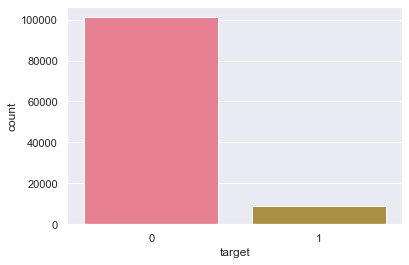

In [7]:
target = "target"

sns.countplot(train_df[target]);

In [8]:
bki_df = get_input(f'{path}/bki.csv')

row_data/bki.csv: shape = 945234 rows, 17 cols


In [9]:
client_profile_df = get_input(f'{path}/client_profile.csv')

row_data/client_profile.csv: shape = 250000 rows, 24 cols


In [10]:
payments_df = get_input(f'{path}/payments.csv')

row_data/payments.csv: shape = 1023932 rows, 8 cols


In [11]:
applications_history_df = get_input(f'{path}/applications_history.csv')

row_data/applications_history.csv: shape = 1670214 rows, 26 cols


In [12]:
train_client_profile = train_df.merge(client_profile_df, how='left')

In [13]:
test_client_profile = test_df.merge(client_profile_df, how='left')

### Пропуски

In [14]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [15]:
check_missings(train_client_profile)

Total NA-values = 672481


,application_number,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
Total,0,0,0,20554,20554,20554,20554,20559,20554,20554,20554,20554,20554,79560,20554,20554,20555,71002,20748,38285,32613,32613,32613,32613,32613,32613
Percent,0,0,0,18.6697,18.6697,18.6697,18.6697,18.6742,18.6697,18.6697,18.6697,18.6697,18.6697,72.2662,18.6697,18.6697,18.6706,64.4927,18.8459,34.7751,29.6231,29.6231,29.6231,29.6231,29.6231,29.6231
Types,int64,int64,object,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [16]:
check_missings(test_client_profile)

Total NA-values = 1012213


,application_number,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
Total,0,0,30965,30965,30965,30965,30971,30965,30965,30965,30965,30965,119640,30965,30965,30966,106506,31250,57641,49104,49104,49104,49104,49104,49104
Percent,0,0,18.7506,18.7506,18.7506,18.7506,18.7543,18.7506,18.7506,18.7506,18.7506,18.7506,72.4472,18.7506,18.7506,18.7512,64.494,18.9232,34.9041,29.7346,29.7346,29.7346,29.7346,29.7346,29.7346
Types,int64,object,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Построение списков признаков

#### Количественные признаки

In [17]:
quantitative_features = train_client_profile.select_dtypes('int64').drop(columns=['target', 'application_number']).columns.tolist()
quantitative_features

[]

#### Категориальные признаки

In [18]:
cat_features = train_client_profile.select_dtypes('object').columns.tolist()
cat_features

['name_contract_type', 'gender', 'education_level', 'family_status']

In [19]:
for col in cat_features:
    print(col)
    print(train_client_profile[col].value_counts())
    print(train_client_profile[col].isnull().sum())
    print()

name_contract_type
Cash           99551
Credit Card    10542
Name: name_contract_type, dtype: int64
0

gender
F      59077
M      30461
XNA        1
Name: gender, dtype: int64
20554

education_level
Secondary / secondary special    63506
Higher education                 21802
Incomplete higher                 3081
Lower secondary                   1113
Academic degree                     37
Name: education_level, dtype: int64
20554

family_status
Married                 57236
Single / not married    13147
Civil marriage           8736
Separated                5763
Widow                    4656
Unknown                     1
Name: family_status, dtype: int64
20554



In [20]:
# train_client_profile[cat_features] = train_client_profile[cat_features].fillna('missing')

In [21]:
# test_client_profile[cat_features] = test_client_profile[cat_features].fillna('missing')

In [22]:
for col in cat_features:
    train_client_profile[col] = train_client_profile[col].astype('str')
    test_client_profile[col] = test_client_profile[col].astype('str')

In [23]:
train_client_profile[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 4 columns):
name_contract_type    110093 non-null object
gender                110093 non-null object
education_level       110093 non-null object
family_status         110093 non-null object
dtypes: object(4)
memory usage: 4.2+ MB


#### Вещественные признаки

In [24]:
float_features = train_client_profile.select_dtypes('float64').columns.tolist()
len(float_features)

20

In [25]:
train_nunique = train_client_profile[float_features].apply(lambda x: x.nunique(dropna=False))
train_nunique.shape

(20,)

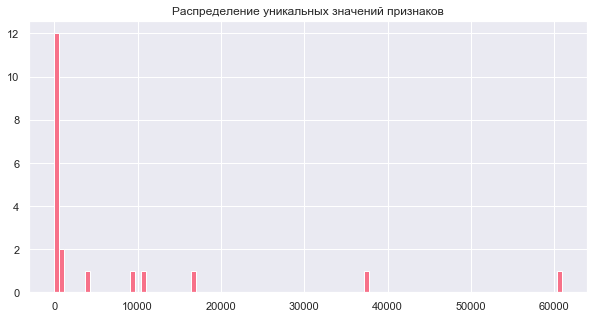

In [26]:
plt.title("Распределение уникальных значений признаков");
train_nunique.hist(bins=100, figsize=(10, 5));

In [27]:
all_features = set(train_nunique.index.tolist())
len(all_features)

20

In [28]:
const_features = set(train_nunique[train_nunique == 1].index.tolist())
const_features

set()

In [29]:
numeric_features = (train_client_profile[float_features].fillna(0).astype(int).sum() - train_client_profile[float_features].fillna(0).sum()).abs()
numeric_features = set(numeric_features[numeric_features > 0].index.tolist())
len(numeric_features)

7

In [30]:
train_client_profile[numeric_features].describe()

,amount_credit,amount_annuity,total_salary,region_population,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3
count,8.953900e+04,89534.000000,8.953900e+04,89539.000000,39091.000000,89345.000000,71808.000000
mean,5.997495e+05,27119.655449,1.683230e+05,0.020843,0.501400,0.513890,0.511020
std,4.031694e+05,14503.018565,9.962278e+04,0.013797,0.209929,0.191253,0.195153
min,4.500000e+04,1615.500000,2.565000e+04,0.000533,0.014691,0.000010,0.000527
25%,2.700000e+05,16524.000000,1.125000e+05,0.010006,0.334582,0.391285,0.370650
50%,5.177880e+05,24903.000000,1.485000e+05,0.018850,0.504836,0.565177,0.535276
75%,8.086500e+05,34596.000000,2.025000e+05,0.028663,0.671532,0.663661,0.669057
max,4.050000e+06,225000.000000,4.500000e+06,0.072508,0.951624,0.855000,0.896010


In [31]:
train_client_profile[numeric_features].isnull().sum()

amount_credit                20554
amount_annuity               20559
total_salary                 20554
region_population            20554
external_scoring_rating_1    71002
external_scoring_rating_2    20748
external_scoring_rating_3    38285
dtype: int64

In [32]:
other = all_features - (numeric_features | const_features)
len(other)

13

#### Бинарные признаки

In [33]:
boolean = set(train_client_profile.loc[:, other].columns[(
                      (train_client_profile.loc[:, other].max() == 1) & \
                      (train_client_profile.loc[:, other].min() == 0))])
len(boolean)

2

In [34]:
for col in boolean:
    print(col)
    print(train_client_profile[col].value_counts())
    print(train_client_profile[col].isnull().sum())
    print()

flag_phone
0.0    64272
1.0    25267
Name: flag_phone, dtype: int64
20554

flag_email
0.0    84581
1.0     4958
Name: flag_email, dtype: int64
20554



In [35]:
train_client_profile['flag_phone'] = train_client_profile['flag_phone'].fillna(0)
train_client_profile['flag_phone'] = train_client_profile['flag_phone'].astype('int')

In [36]:
test_client_profile['flag_phone'] = test_client_profile['flag_phone'].fillna(0)
test_client_profile['flag_phone'] = test_client_profile['flag_phone'].astype('int')

In [37]:
train_client_profile['flag_email'] = train_client_profile['flag_email'].fillna(0)
train_client_profile['flag_email'] = train_client_profile['flag_email'].astype('int')
test_client_profile['flag_email'] = test_client_profile['flag_email'].fillna(0)
test_client_profile['flag_email'] = test_client_profile['flag_email'].astype('int')

In [38]:
other = other - boolean
len(other)

11

In [39]:
train_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 26 columns):
application_number            110093 non-null int64
target                        110093 non-null int64
name_contract_type            110093 non-null object
gender                        110093 non-null object
childrens                     89539 non-null float64
total_salary                  89539 non-null float64
amount_credit                 89539 non-null float64
amount_annuity                89534 non-null float64
education_level               110093 non-null object
family_status                 110093 non-null object
region_population             89539 non-null float64
age                           89539 non-null float64
days_on_last_job              89539 non-null float64
own_car_age                   30533 non-null float64
flag_phone                    110093 non-null int32
flag_email                    110093 non-null int32
family_size                   89538 non-null 

In [40]:
# train_client_profile['own_car_age'] = train_client_profile['own_car_age'].fillna(-1)
# train_client_profile['own_car_age'] = train_client_profile['own_car_age'].astype('int')
# test_client_profile['own_car_age'] = test_client_profile['own_car_age'].fillna(-1)
# test_client_profile['own_car_age'] = test_client_profile['own_car_age'].astype('int')

In [41]:
numeric_features = numeric_features | other

In [42]:
other = other - numeric_features
len(other)

0

In [43]:
train_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 26 columns):
application_number            110093 non-null int64
target                        110093 non-null int64
name_contract_type            110093 non-null object
gender                        110093 non-null object
childrens                     89539 non-null float64
total_salary                  89539 non-null float64
amount_credit                 89539 non-null float64
amount_annuity                89534 non-null float64
education_level               110093 non-null object
family_status                 110093 non-null object
region_population             89539 non-null float64
age                           89539 non-null float64
days_on_last_job              89539 non-null float64
own_car_age                   30533 non-null float64
flag_phone                    110093 non-null int32
flag_email                    110093 non-null int32
family_size                   89538 non-null 

In [44]:
numeric_features = train_client_profile.select_dtypes(include=['number']).drop(
    columns=['target', 'application_number']).columns.tolist()
len(numeric_features)

20

In [45]:
# train_client_profile[numeric_features].fillna(-1, inplace=True)

In [46]:
# test_client_profile[numeric_features].fillna(-1, inplace=True)

### Распределение признаков в зависимости от целевой переменной

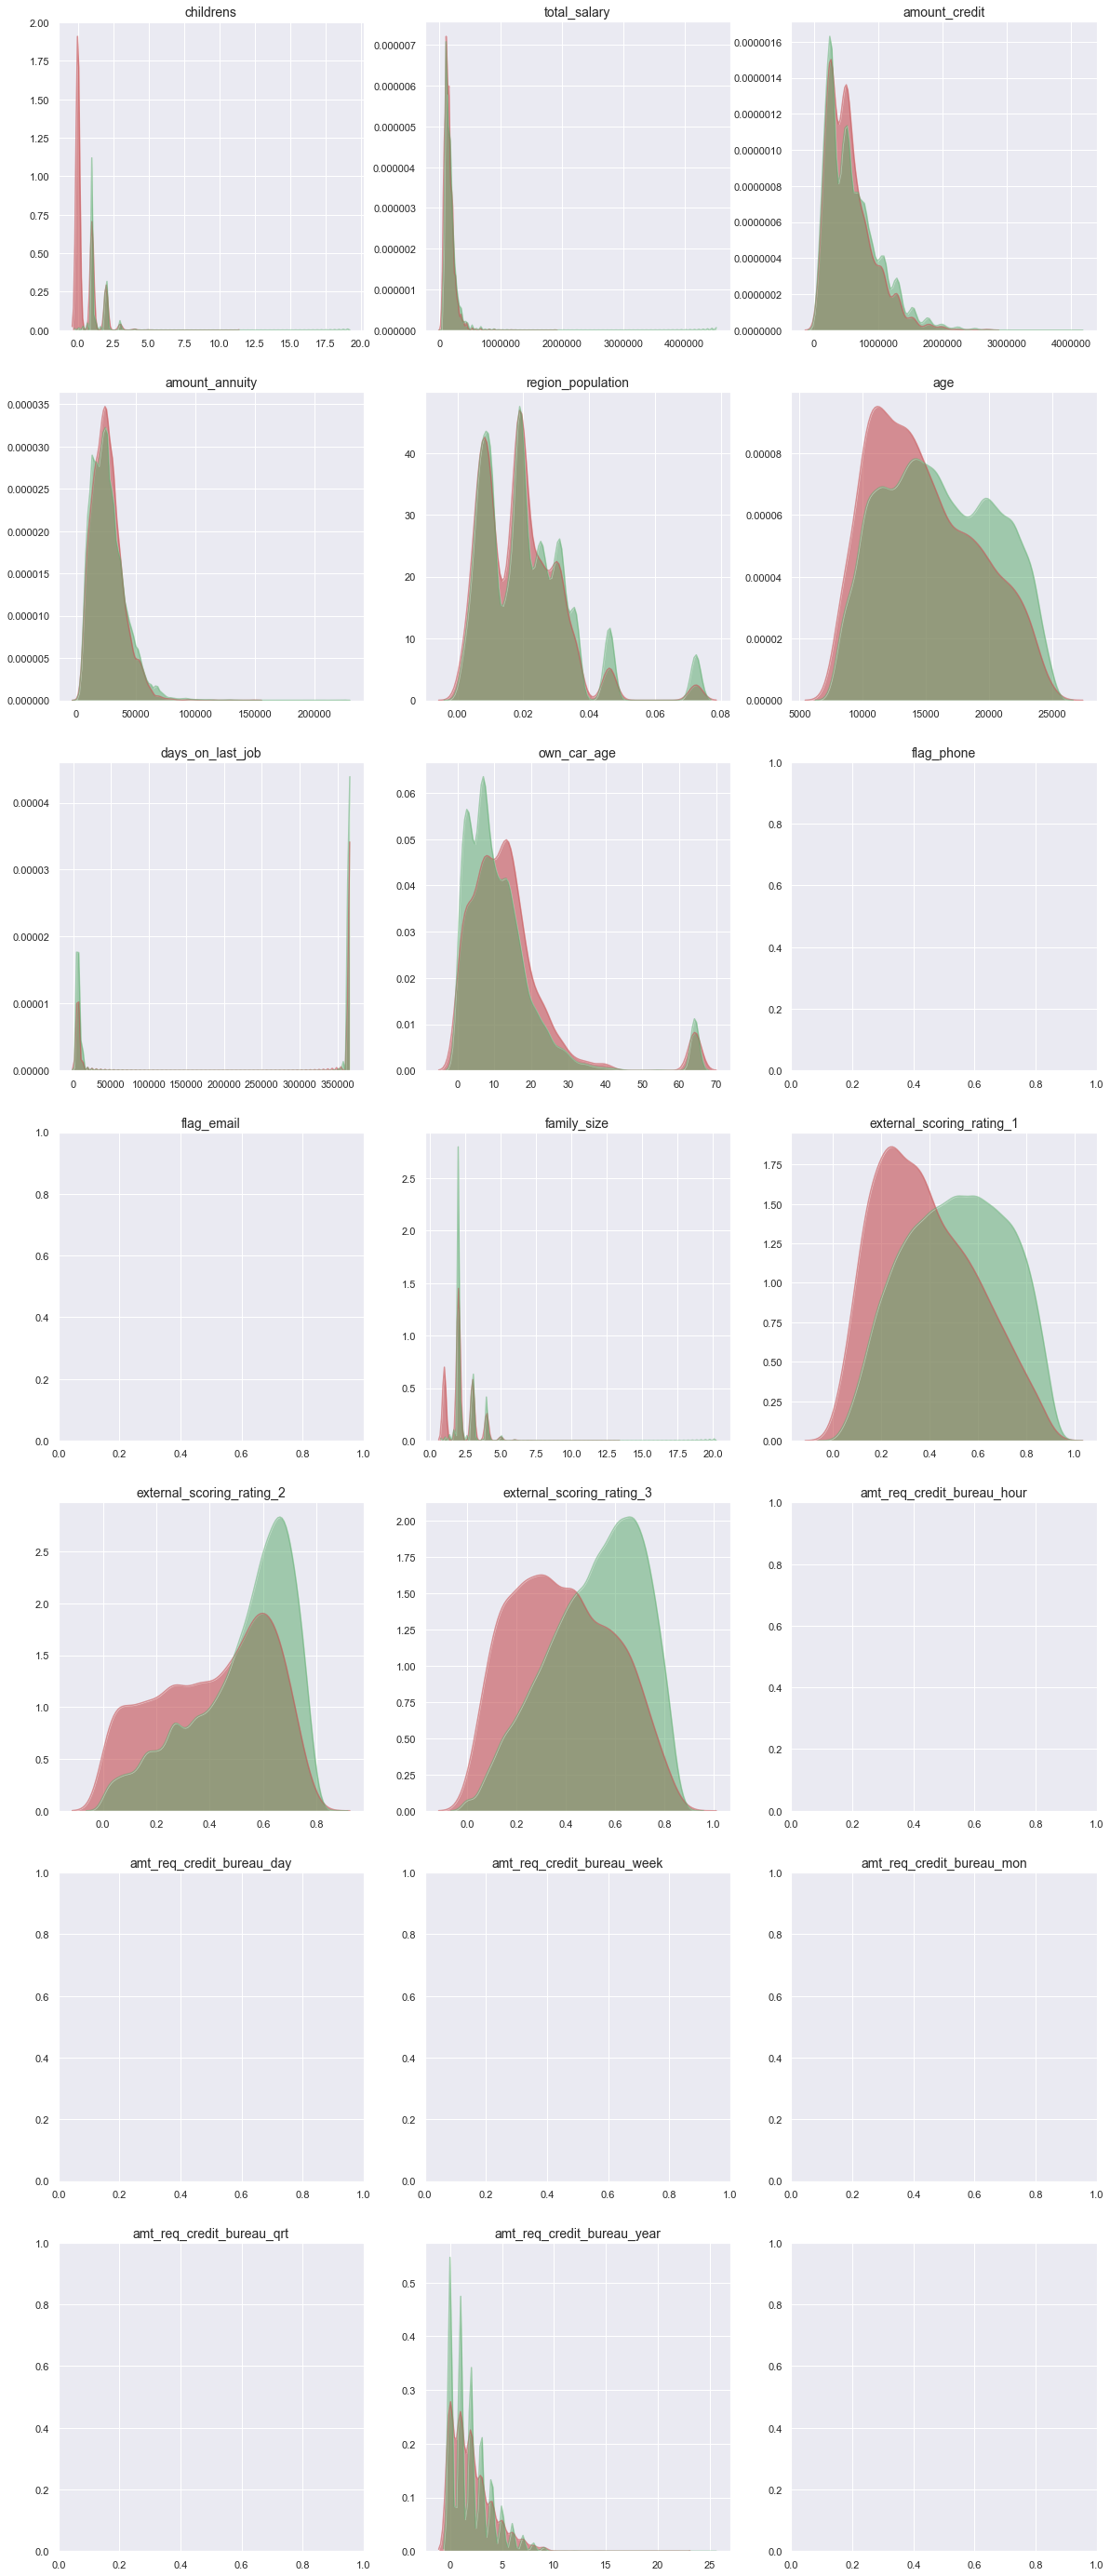

In [47]:
fig, axes = plt.subplots(7, 3, figsize=(20, 50))

for num, feature in enumerate(numeric_features):
    try:
        sns.kdeplot(train_client_profile.loc[train_client_profile[target] == 1, feature], ax=axes[num//3, num%3], 
                    shade=True, alpha=0.6, legend=False, color='r')
        sns.kdeplot(train_client_profile.loc[train_client_profile[target] == 0, feature], ax=axes[num//3, num%3], 
                    shade=True, alpha=0.5, legend=False, color='g')
    except RuntimeError:
        pass
    axes[num//3, num%3].set_title(feature, fontsize=14)
plt.show()

### Сравнение распределений признаков в обучающей и валидационной выборках

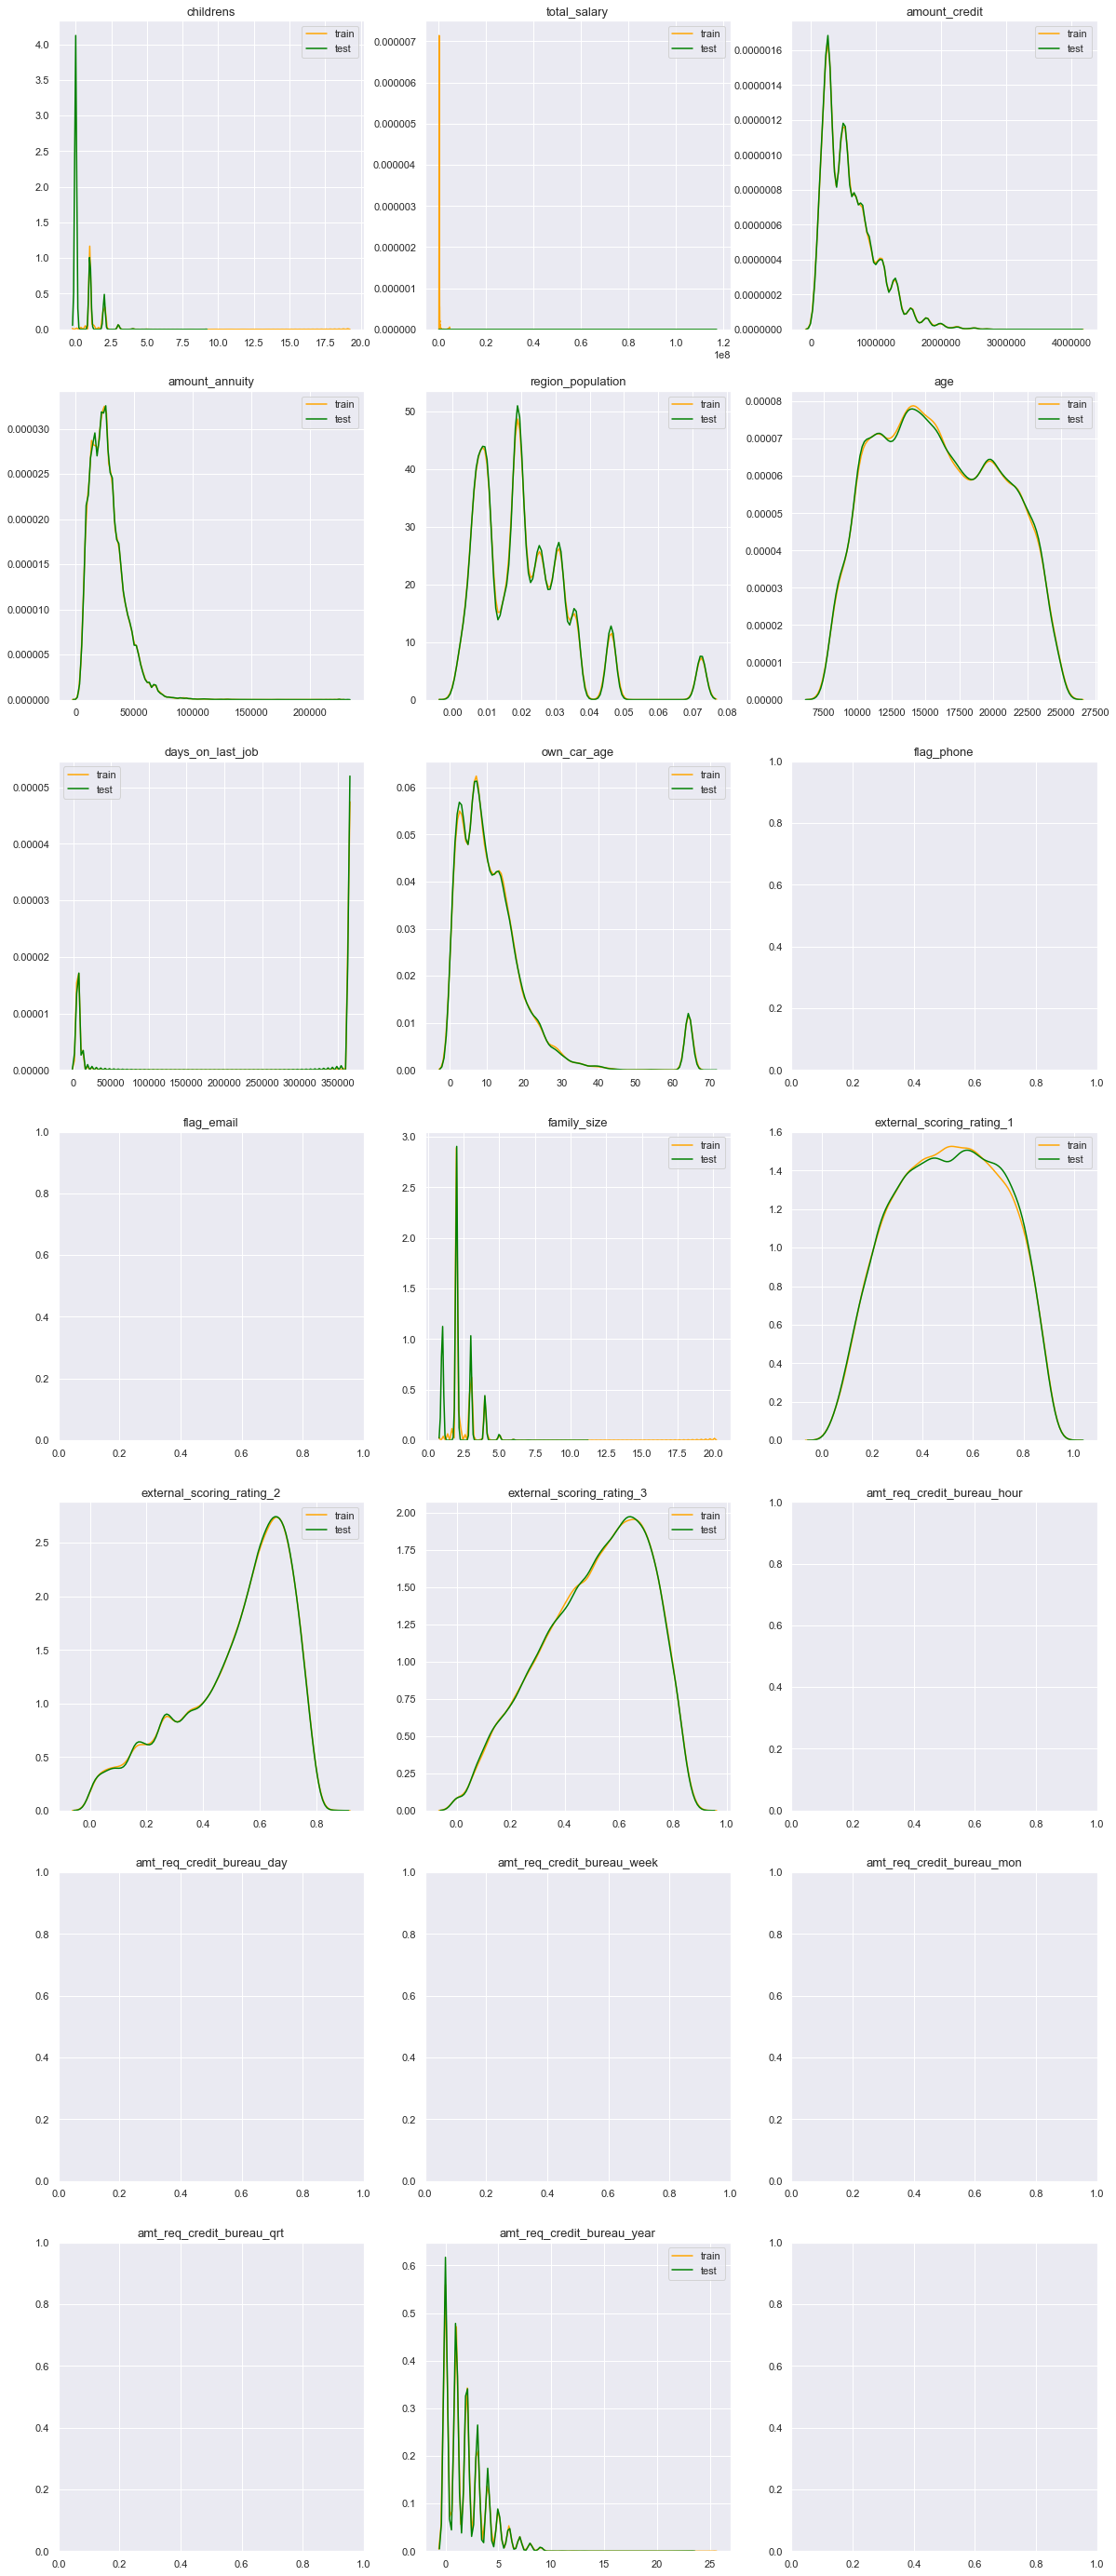

In [48]:
fig, axes = plt.subplots(7, 3, figsize=(20, 50))

for num, feature in enumerate(numeric_features):
    try:
        train_data, test_data = train_client_profile[feature].copy(), test_client_profile[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="orange", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
    axes[num//3, num%3].set_title(feature, fontsize=13)
plt.show()

### Распределение основных статистик признаков в разрезе целевой переменной

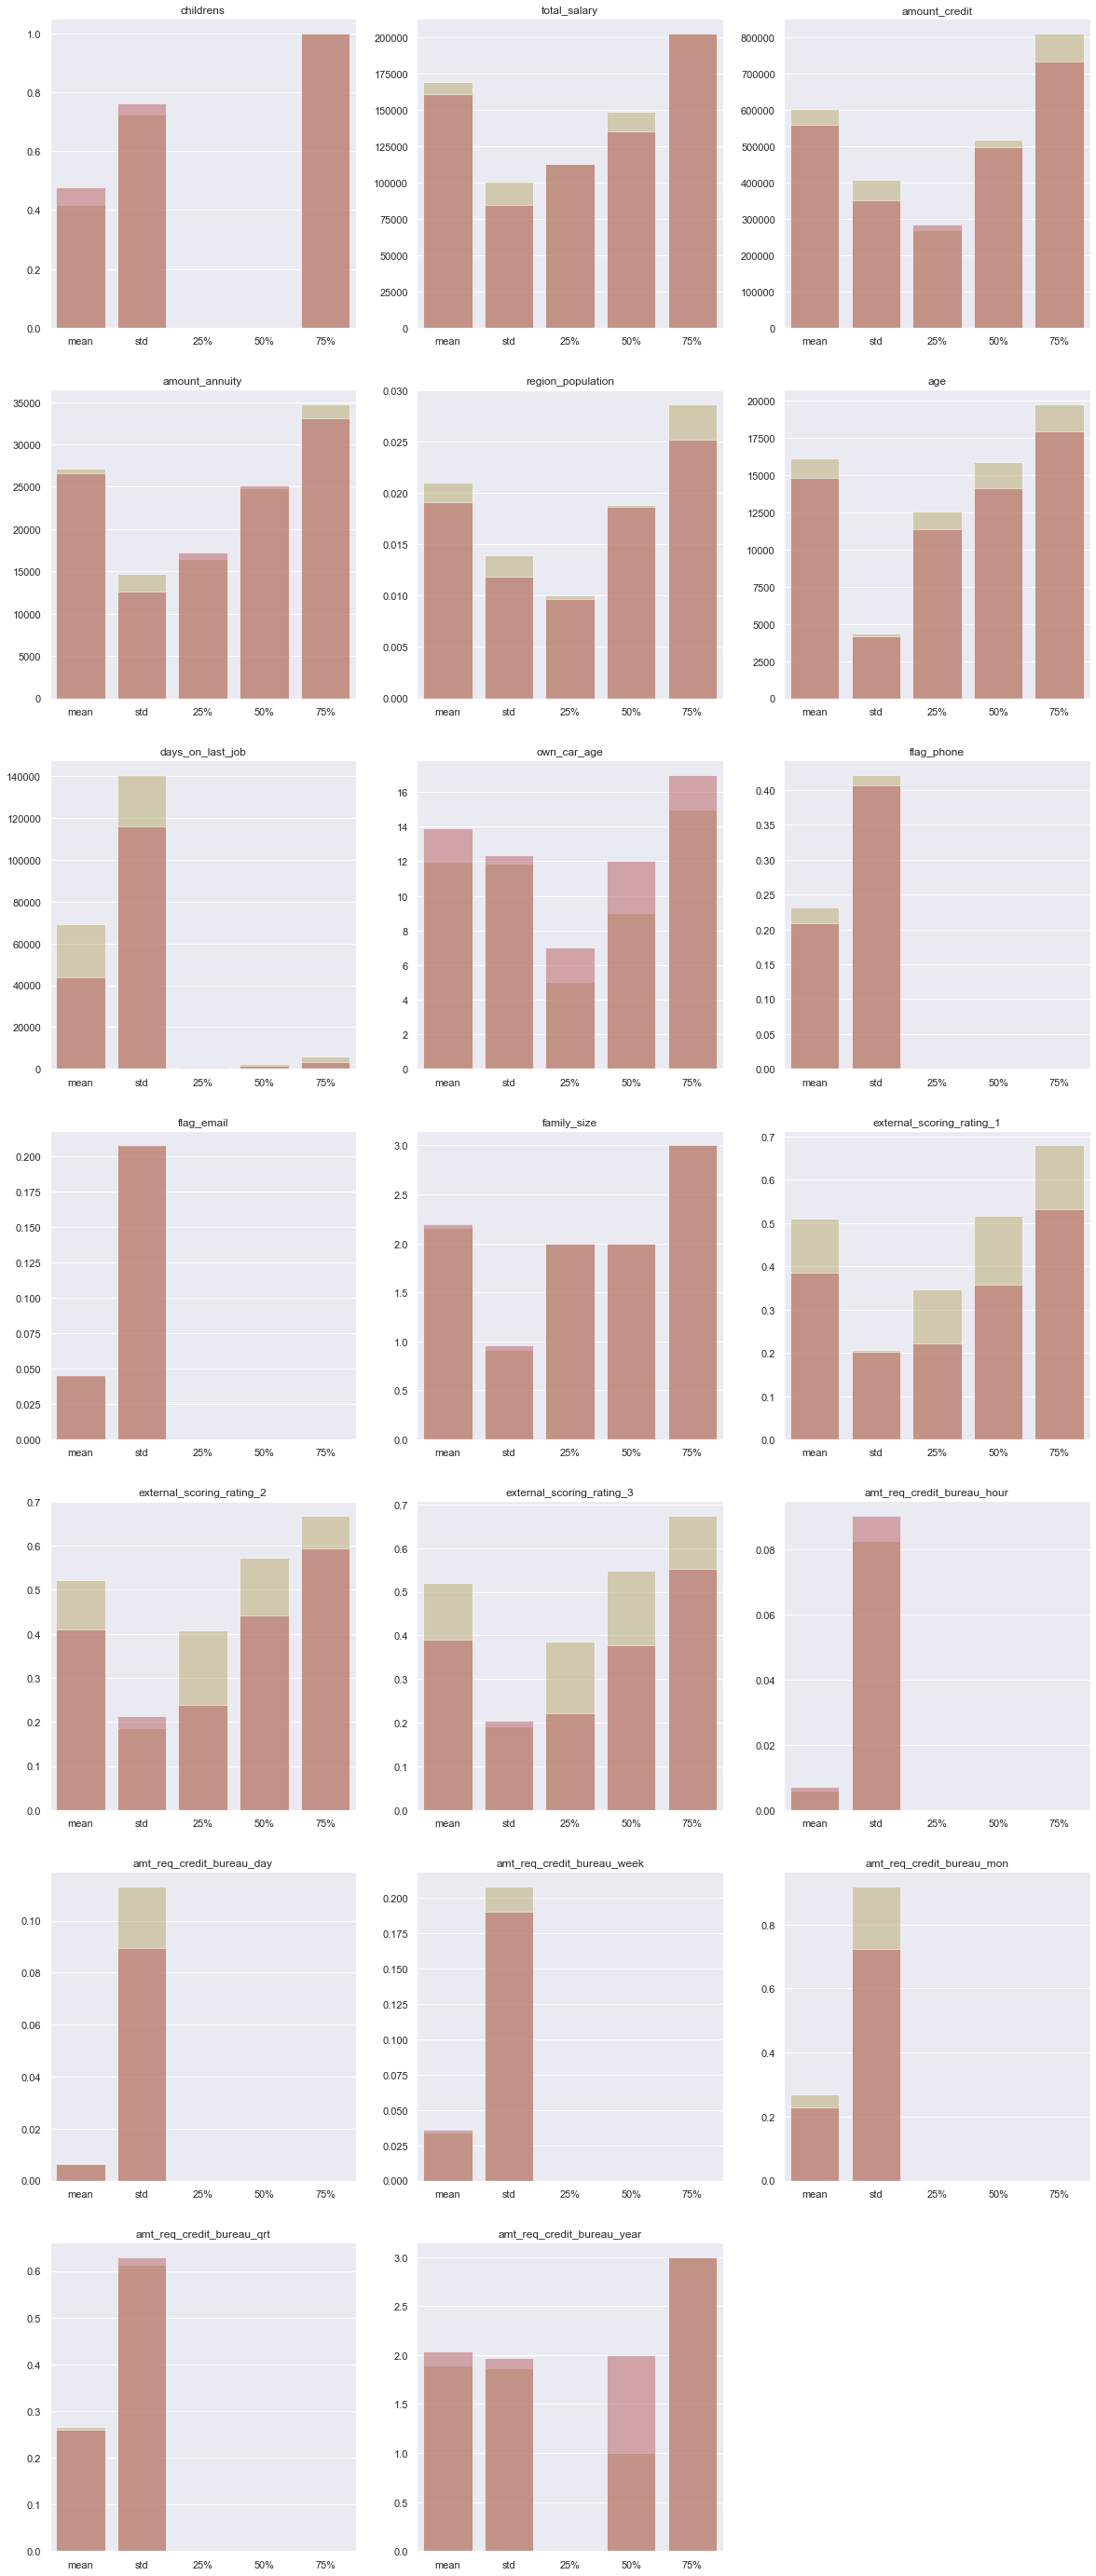

In [49]:
plt.figure(figsize=(20,50))

for num, feature in enumerate(numeric_features):
    plt.subplot(7,3,num+1)
    plt.title(feature)
    
    train_stat_t0 = train_client_profile.loc[train_client_profile[target] == 0, feature].describe().drop(
        ['count', 'max', 'min'], axis=0)
    train_stat_t1 = train_client_profile.loc[train_client_profile[target] == 1, feature].describe().drop(
        ['count', 'max', 'min'], axis=0)
    
    sns.barplot(train_stat_t0.index, train_stat_t0.values, alpha=0.6, color='y')
    sns.barplot(train_stat_t1.index, train_stat_t1.values, alpha=0.5, color='r')
    
plt.show()

### Сравнение распределения основных статистик признаков в трейне и тесте

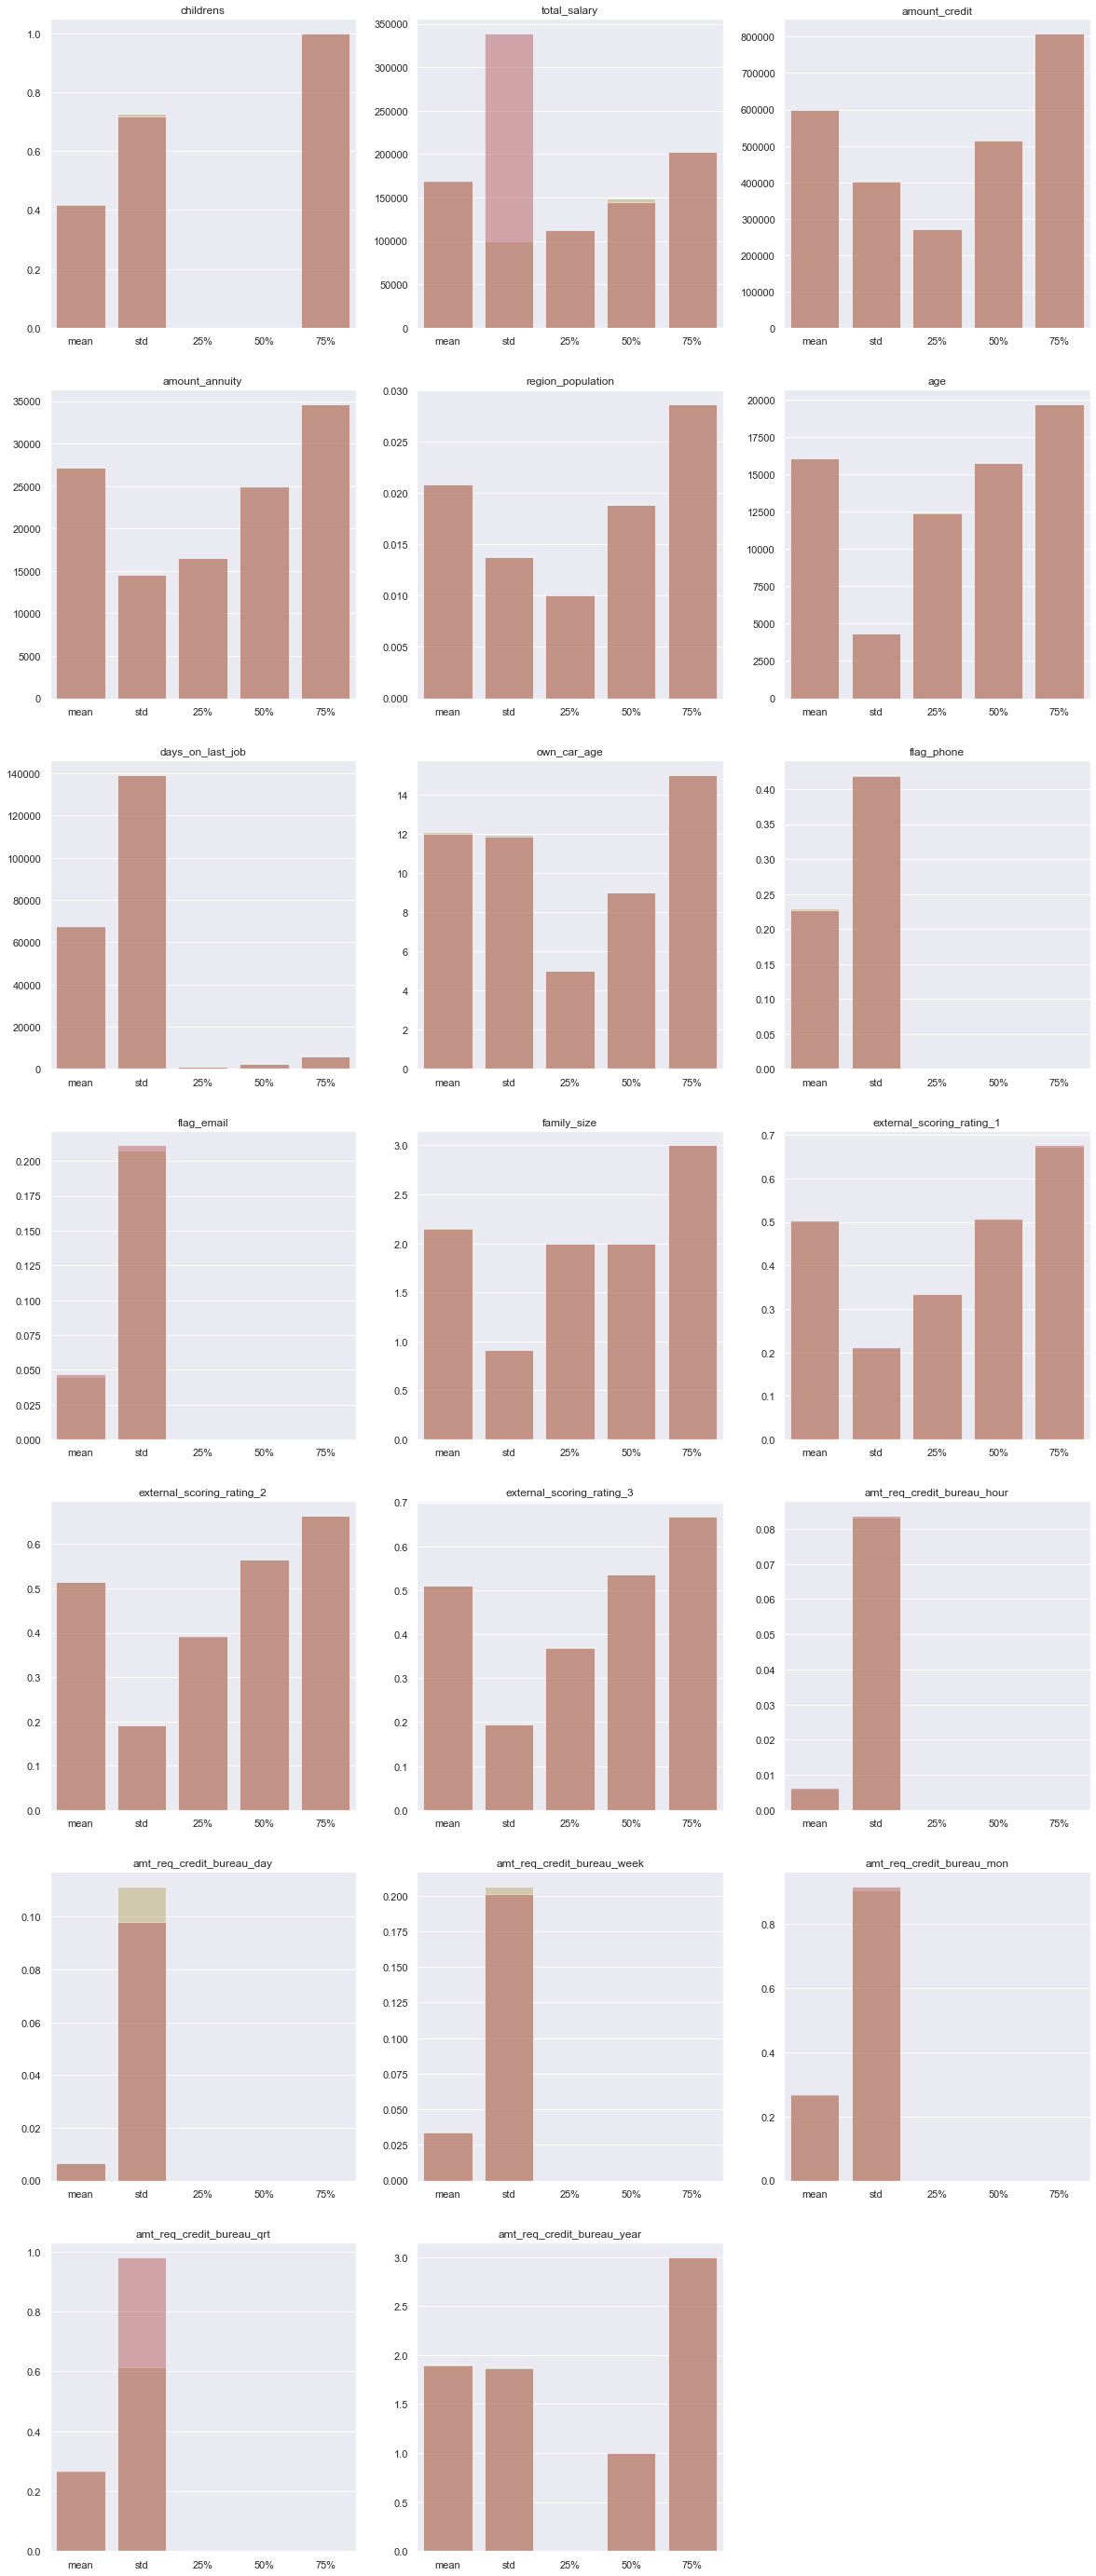

In [50]:
plt.figure(figsize=(20,50))

for num, feature in enumerate(numeric_features):
    plt.subplot(7,3,num+1)
    plt.title(feature)
    
    train_stat = train_client_profile[feature].describe().drop(['count', 'max', 'min'], axis=0)
    test_stat = test_client_profile[feature].describe().drop(['count', 'max', 'min'], axis=0)
    
    sns.barplot(train_stat.index, train_stat.values, alpha=0.6, color='y')
    sns.barplot(test_stat.index, test_stat.values, alpha=0.5, color='r')
    
plt.show()

### Корреляция признаков с целевой переменной

In [51]:
correlation = train_client_profile.corr()
corr_with_target = correlation['target'].sort_values(ascending = False)
corr_with_target[abs(corr_with_target) > 0.2]

target    1.0
Name: target, dtype: float64

Text(0, 0.5, 'Density')

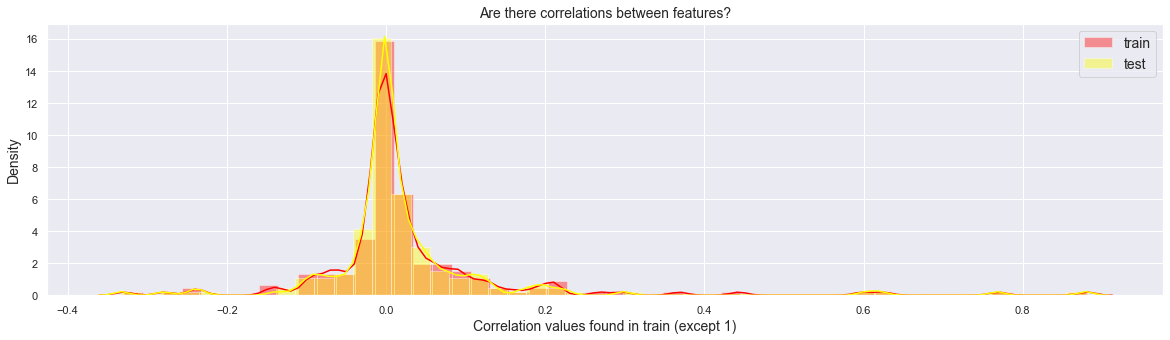

In [52]:
train_correlations = train_client_profile[numeric_features].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test_client_profile[numeric_features].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Yellow", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

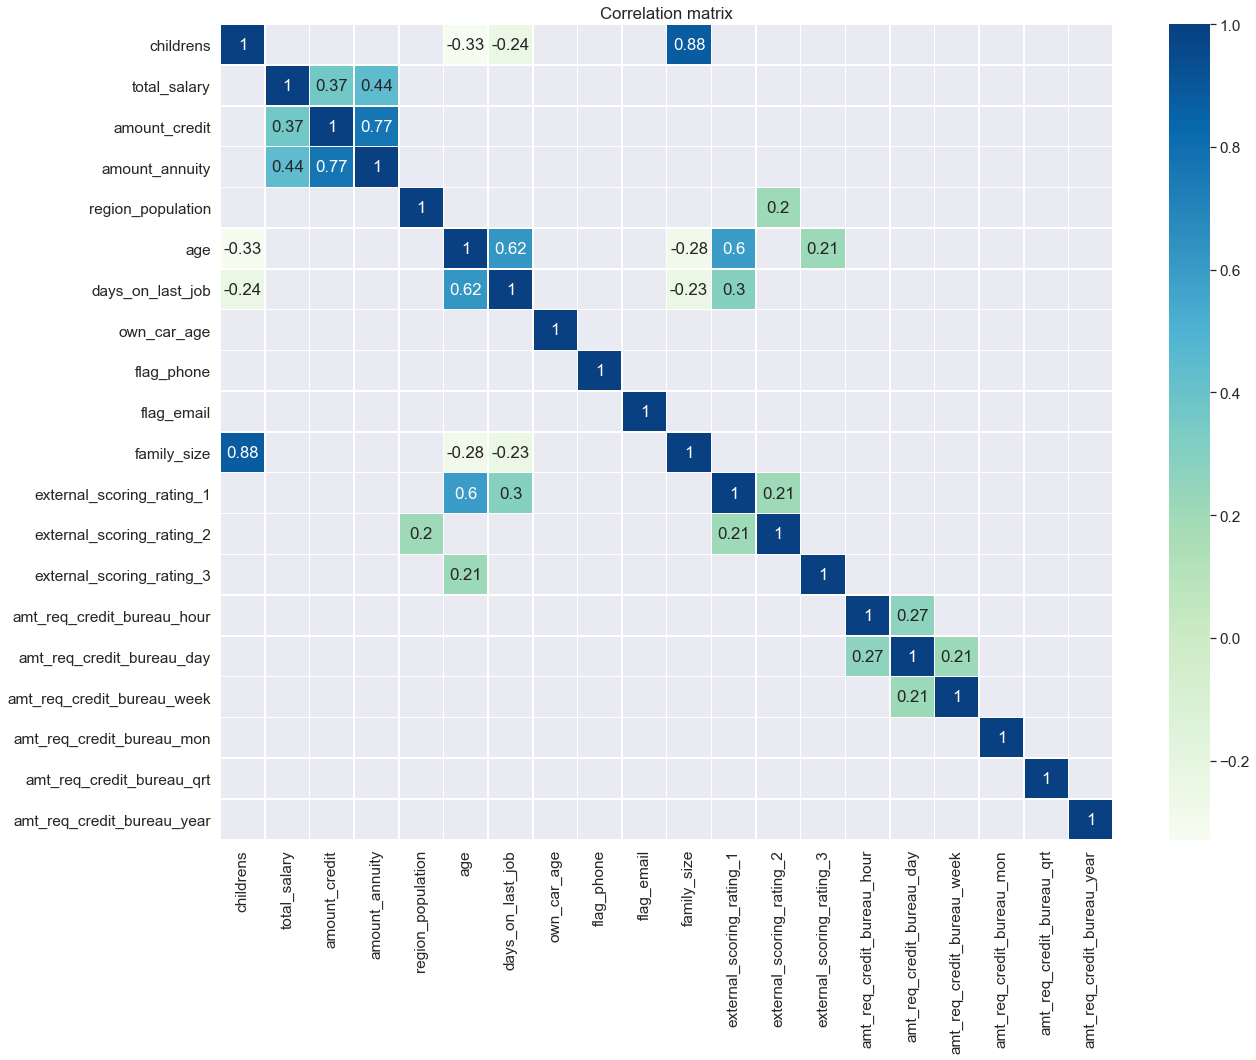

In [53]:
correlation = abs(train_client_profile[numeric_features].corr()) > 0.2

plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_client_profile[numeric_features].corr()[correlation], annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

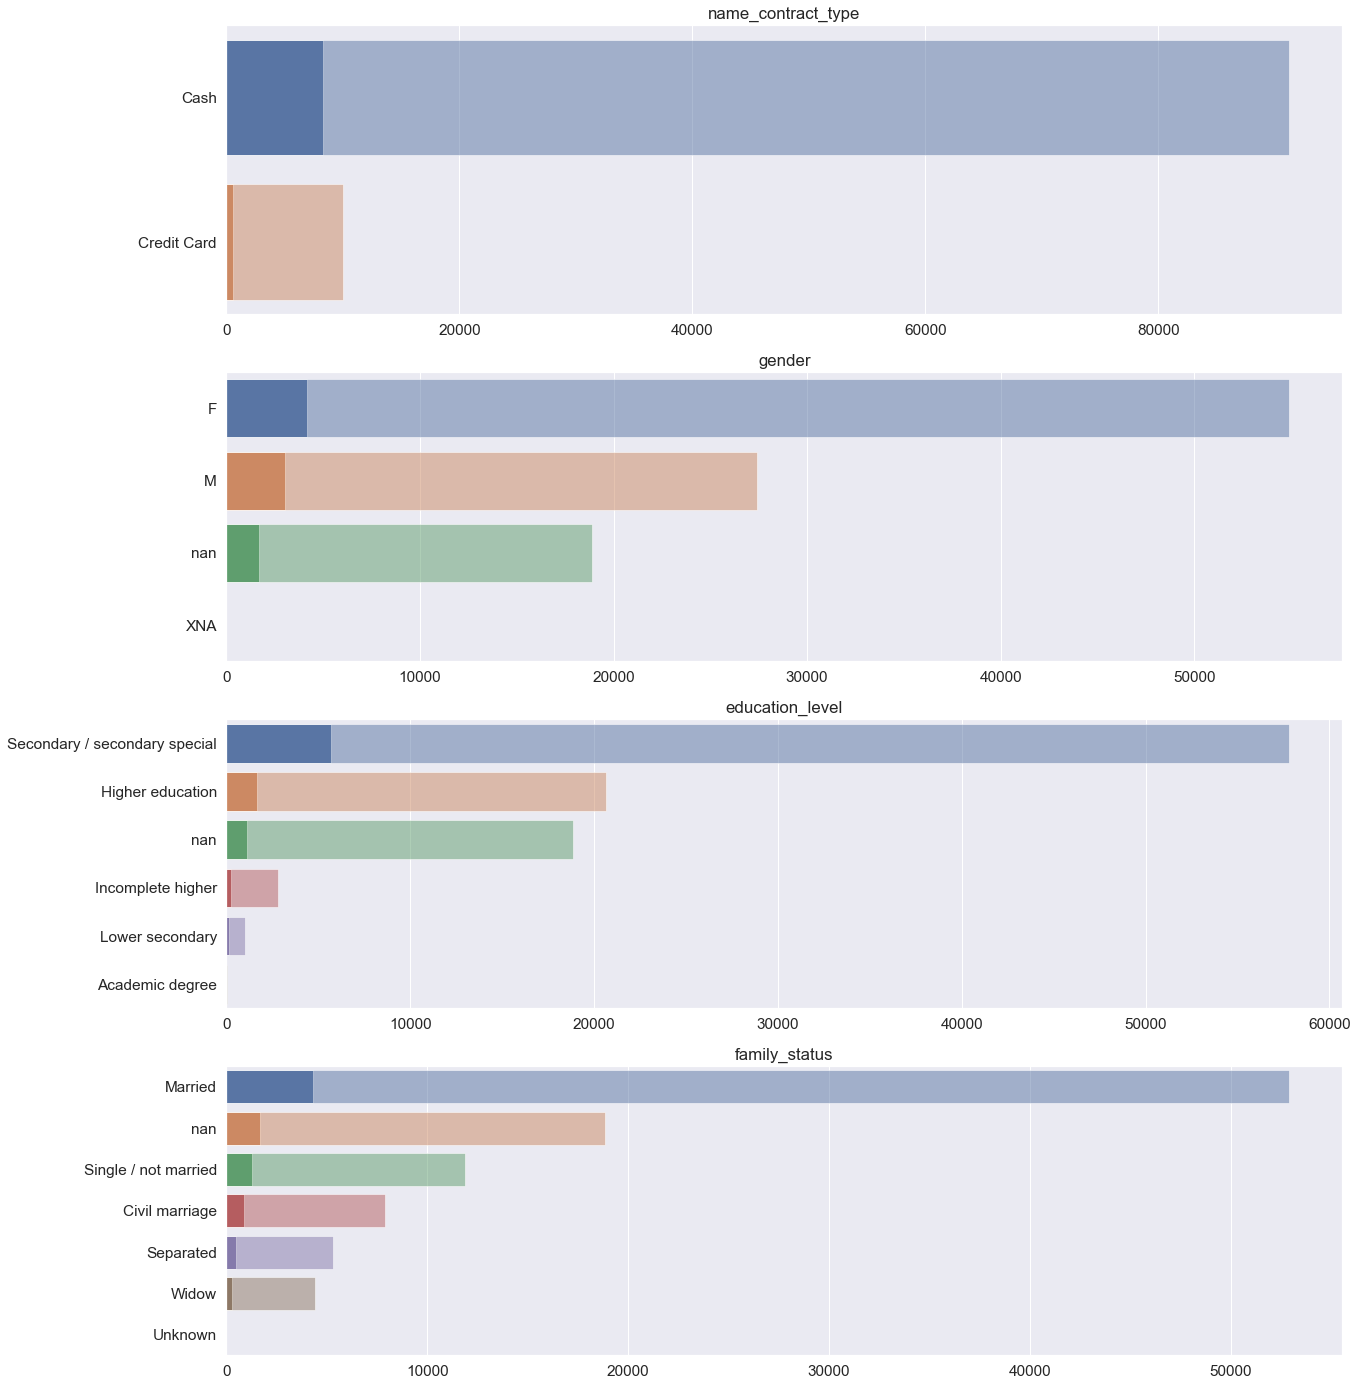

In [54]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,50))

for i, colname in enumerate(cat_features):
    plt.subplot(8,1,i+1)
    plt.title(colname)
    
    val_counts_t1 = train_client_profile.loc[train_client_profile['target'] == 1, colname].value_counts()
    val_counts_t0 = train_client_profile.loc[train_client_profile['target'] == 0, colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index)
    sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5)
    
plt.show()